In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Load data
data5c = pd.read_csv("question5b.csv", header=None)
col_name_years = list(data5c.values.ravel())
data5a = pd.read_csv("question5a.csv", names=col_name_years)
data5b = pd.read_csv("question5c.csv", names=["months"])
data5 = pd.concat([data5a, data5b], axis=1)
new_data5 = pd.melt(data5, id_vars=["months"], value_vars=list(data5.columns[:-1]), value_name="passengers")
dates = pd.date_range(start='1949-01-01', freq='M', periods=len(new_data5))
new_data5['Date'] = dates
new_data5.set_index('Date', inplace=True)

In [2]:
new_data5

,months,variable,passengers
Date,,,
1949-01-31,Jan,1949,112
1949-02-28,Feb,1949,118
1949-03-31,Mar,1949,132
1949-04-30,Apr,1949,129
1949-05-31,May,1949,121
...,...,...,...
1960-08-31,Aug,1960,606
1960-09-30,Sep,1960,508
1960-10-31,Oct,1960,461


In [3]:

# Linear Regression Model
X_linear = np.arange(len(new_data5)).reshape(-1, 1)
y_linear = new_data5["passengers"].values.reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(X_linear, y_linear)

LinearRegression()

In [4]:
# Neural Network Model(MLP)
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(y_linear)
X_nn = np.arange(len(new_data5)).reshape(-1, 1)
y_nn = scaled_data.reshape(-1, 1)
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
nn_model.fit(X_nn, y_nn.ravel())

MLPRegressor(max_iter=1000)

In [5]:
# Generate prediction dates for '1961-01-01' to '1961-12-31'
prediction_dates = pd.date_range(start='1961-01-01', end='1961-12-31', freq='M')
X_pred_linear = np.arange(len(new_data5), len(new_data5) + len(prediction_dates)).reshape(-1, 1)
X_pred_nn = np.arange(len(new_data5), len(new_data5) + len(prediction_dates)).reshape(-1, 1)

# Linear Regression Predictions
linear_pred = linear_model.predict(X_pred_linear)

# Neural Network Predictions
nn_pred_scaled = nn_model.predict(X_pred_nn)
nn_pred = scaler.inverse_transform(nn_pred_scaled.reshape(-1, 1))

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(index=prediction_dates)
predictions_df['Linear Regression'] = linear_pred.flatten()
predictions_df['Neural Network'] = nn_pred.flatten()

# Display the predictions
print(predictions_df)

            Linear Regression  Neural Network
1961-01-31         472.944444      831.137801
1961-02-28         475.601628      836.604295
1961-03-31         478.258812      842.070789
1961-04-30         480.915996      847.537283
1961-05-31         483.573180      853.003777
1961-06-30         486.230364      858.470271
1961-07-31         488.887548      863.936765
1961-08-31         491.544732      869.403259
1961-09-30         494.201916      874.869753
1961-10-31         496.859100      880.336247
1961-11-30         499.516284      885.802741
1961-12-31         502.173467      891.269235


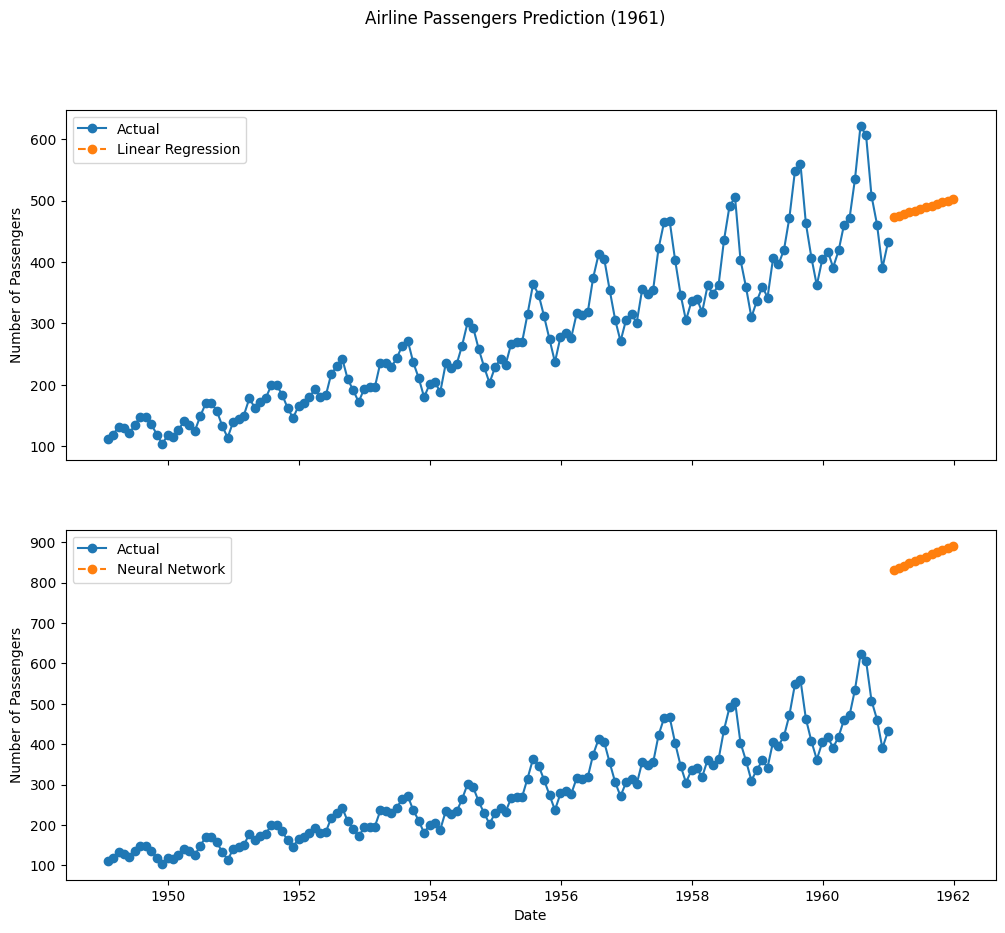

In [6]:
# Plotting the results as two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot Actual vs Linear Regression
axes[0].plot(new_data5.index, new_data5["passengers"], label="Actual", marker='o')
axes[0].plot(prediction_dates, predictions_df['Linear Regression'], label="Linear Regression", linestyle='dashed', marker='o')
axes[0].set_ylabel('Number of Passengers')
axes[0].legend()

# Plot Actual vs Neural Network
axes[1].plot(new_data5.index, new_data5["passengers"], label="Actual", marker='o')
axes[1].plot(prediction_dates, predictions_df['Neural Network'], label="Neural Network", linestyle='dashed', marker='o')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Passengers')
axes[1].legend()

plt.suptitle('Airline Passengers Prediction (1961)')
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming new_data5 is already loaded as described

# Normalize the data
scaler_lstm = MinMaxScaler()
scaled_lstm_data = scaler_lstm.fit_transform(new_data5["passengers"].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:i+seq_length]
        seq_y = data[i+seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Choose sequence length (number of time steps to look back)
seq_length = 12  # You can experiment with different values

# Create sequences for LSTM
X_lstm, y_lstm = create_sequences(scaled_lstm_data, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X_lstm))

X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Reshape input data to be 3D [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# Make predictions
y_pred_lstm_scaled = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_lstm.inverse_transform(y_pred_lstm_scaled)
# Save the LSTM model
model_lstm.save('lstm_model.h5')

Epoch 1/50
4/4 [==============================] - 1s 54ms/step - loss: 0.1224 - val_loss: 0.4137
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: 0.1000 - val_loss: 0.3443
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0801 - val_loss: 0.2785
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0616 - val_loss: 0.2159
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.1526
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0277 - val_loss: 0.0876
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0163 - val_loss: 0.0348
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0145 - val_loss: 0.0206
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0216
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0119 - val_loss: 0.0296
Epoch 11/50
4/4 [====================

/dev1/genomeGPT/anaconda3/envs/optinum/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


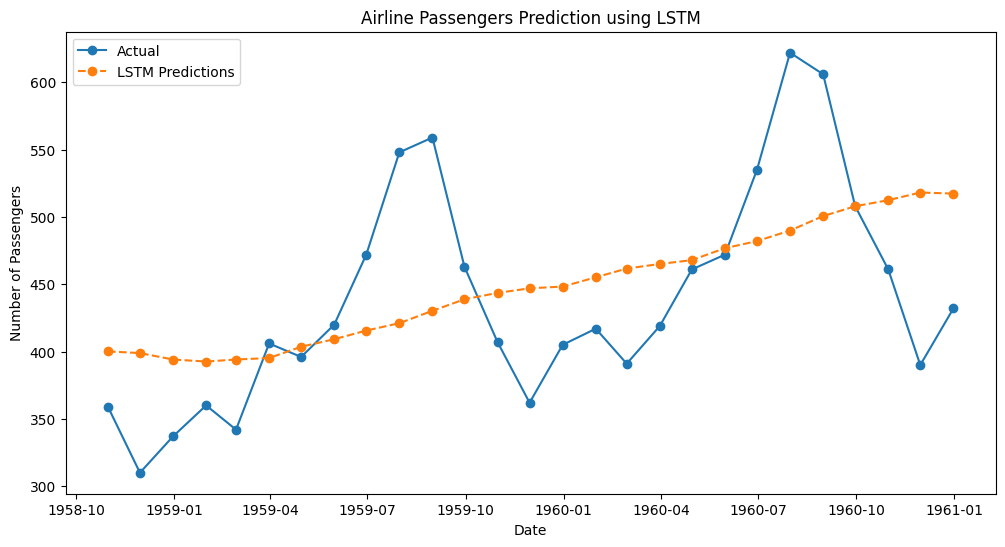

In [15]:
# Plot results
plt.figure(figsize=(12, 6))

# Actual vs LSTM predictions
plt.plot(new_data5.index[split_index+seq_length:], new_data5["passengers"].values[split_index+seq_length:], label="Actual", marker='o')
plt.plot(new_data5.index[split_index+seq_length:], y_pred_lstm.flatten(), label="LSTM Predictions", linestyle='dashed', marker='o')

plt.title('Airline Passengers Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [23]:
# Load the LSTM model
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_model.h5')

# Generate prediction dates for '1961-01-01' to '1961-12-31'
prediction_dates = pd.date_range('1961-01-01', '1961-12-31', freq='M')

# Create sequences for the future timeline
X_future_lstm, _ = create_sequences(X_train_lstm[-seq_length:], seq_length)

In [24]:
X_future_lstm

array([], dtype=float64)

In [21]:
prediction_dates

DatetimeIndex(['1961-01-31', '1961-02-28', '1961-03-31', '1961-04-30',
               '1961-05-31', '1961-06-30', '1961-07-31', '1961-08-31',
               '1961-09-30', '1961-10-31', '1961-11-30', '1961-12-31'],
              dtype='datetime64[ns]', freq='M')

5/5 [==============================] - 0s 657us/step


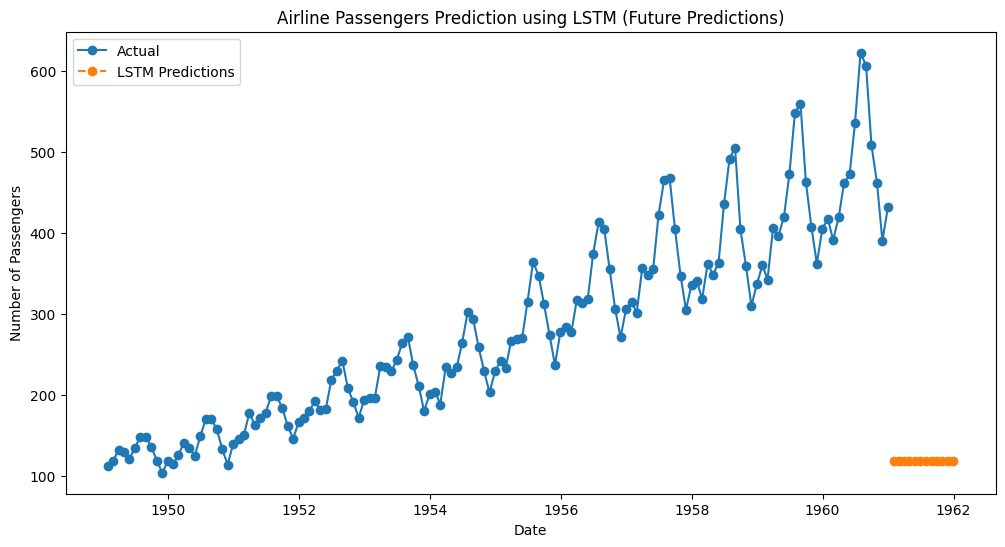

In [25]:
# Reshape input data to be 3D [samples, timesteps, features]
#X_future_lstm = X_future_lstm.reshape((X_future_lstm.shape[0], X_future_lstm.shape[1], 1))

# Make predictions for the future timeline using the loaded model
y_future_scaled = []
for _ in range(len(prediction_dates)):
    y_future_step_scaled = loaded_model.predict(scaled_lstm_data)
    y_future_scaled.append(y_future_step_scaled.flatten()[0])

# Inverse transform the predicted values
y_future = scaler_lstm.inverse_transform(np.array(y_future_scaled).reshape(-1, 1))

# Create a DataFrame for the predictions with the corresponding dates
predictions_df = pd.DataFrame({'Date': prediction_dates, 'Passengers': y_future.flatten()})
predictions_df.set_index('Date', inplace=True)

# Plot results for the future timeline
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(new_data5.index, new_data5["passengers"].values, label="Actual", marker='o')

# LSTM predictions for the future using the loaded model
plt.plot(predictions_df.index, predictions_df["Passengers"].values, label="LSTM Predictions", linestyle='dashed', marker='o')

plt.title('Airline Passengers Prediction using LSTM (Future Predictions)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


In [26]:
predictions_df

,Passengers
Date,
1961-01-31,118.205673
1961-02-28,118.205673
1961-03-31,118.205673
1961-04-30,118.205673
1961-05-31,118.205673
1961-06-30,118.205673
1961-07-31,118.205673
1961-08-31,118.205673
1961-09-30,118.205673
